# Refactored Data Loading and Preprocessing Pipeline

This notebook implements an efficient pipeline to load, preprocess, and integrate the single-cell RNA sequencing data for this project. It addresses the issues in the original `Data_Loading.ipynb` by:

1.  **Reading data efficiently** directly from compressed files.
2.  **Using `AnnData`** as a unified data structure.
3.  **Integrating sample and feature metadata** from the supplementary files.
4.  **Performing initial quality control** and filtering.
5.  **Saving the processed data** in a convenient format (`.h5ad`) for downstream analysis.

In [ ]:
# Import required libraries for single-cell RNA-seq analysis and data handling
import scanpy as sc  # Main library for single-cell analysis, provides AnnData structure and many tools
import pandas as pd  # For tabular data manipulation and metadata handling
import numpy as np   # For numerical operations and array handling
import os            # For operating system interactions (file paths, etc.)
from pathlib import Path  # For robust and readable file path management

# Print versions to ensure reproducibility and compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

Scanpy version: 1.11.4
Pandas version: 2.2.3


## 1. Load Sample Metadata

First, we load the metadata from the `GSE300475_feature_ref.xlsx` file. This file contains the crucial mapping between GEO sample IDs, patient IDs, timepoints, and treatment response.

In [ ]:
%%time
# --- Setup data paths ---
# Define the main data directory and the subdirectory containing raw files.
data_dir = Path('../Data')
raw_data_dir = data_dir / 'GSE300475_RAW'

# --- Manually create the metadata mapping ---
# This list contains information about each sample, including GEO IDs, patient IDs, timepoints, and response status.
# Note: S8 (GSM9061672) has GEX files but no corresponding TCR file.
metadata_list = [
    # Patient 1 (Responder)
    {'S_Number': 'S1',  'GEX_Sample_ID': 'GSM9061665', 'TCR_Sample_ID': 'GSM9061687', 'Patient_ID': 'PT1',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S2',  'GEX_Sample_ID': 'GSM9061666', 'TCR_Sample_ID': 'GSM9061688', 'Patient_ID': 'PT1',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 2 (Non-Responder)
    {'S_Number': 'S3',  'GEX_Sample_ID': 'GSM9061667', 'TCR_Sample_ID': 'GSM9061689', 'Patient_ID': 'PT2',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S4',  'GEX_Sample_ID': 'GSM9061668', 'TCR_Sample_ID': 'GSM9061690', 'Patient_ID': 'PT2',  'Timepoint': 'Post-Chemo',  'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 3 (Responder)
    {'S_Number': 'S5',  'GEX_Sample_ID': 'GSM9061669', 'TCR_Sample_ID': 'GSM9061691', 'Patient_ID': 'PT3',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S6',  'GEX_Sample_ID': 'GSM9061670', 'TCR_Sample_ID': 'GSM9061692', 'Patient_ID': 'PT3',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 4 (Non-Responder)
    {'S_Number': 'S7',  'GEX_Sample_ID': 'GSM9061671', 'TCR_Sample_ID': 'GSM9061693', 'Patient_ID': 'PT4',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 5 (partial) - S8 exists as GEX only in the raw data but has no TCR file
    {'S_Number': 'S8',  'GEX_Sample_ID': 'GSM9061672', 'TCR_Sample_ID': None,             'Patient_ID': 'PT5',  'Timepoint': 'Unknown',      'Response': 'Unknown',       'In_Data': 'GEX only', 'In_Article': 'Yes'},
    {'S_Number': 'S9',  'GEX_Sample_ID': 'GSM9061673', 'TCR_Sample_ID': 'GSM9061694', 'Patient_ID': 'PT5',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S10', 'GEX_Sample_ID': 'GSM9061674', 'TCR_Sample_ID': 'GSM9061695', 'Patient_ID': 'PT5',  'Timepoint': 'Post-ICI',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 11 (Responder)
    {'S_Number': 'S11', 'GEX_Sample_ID': 'GSM9061675', 'TCR_Sample_ID': 'GSM9061696', 'Patient_ID': 'PT11', 'Timepoint': 'Endpoint',      'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
]

# --- Create DataFrame and display the verification table ---
metadata_df = pd.DataFrame(metadata_list)
print("Metadata table now matches the requested specification:")
display(metadata_df)

# --- Programmatic sanity-check for file presence ---
# This loop checks if the expected files exist for each sample and updates the 'In_Data' column accordingly.
for idx, row in metadata_df.iterrows():
    s = row['S_Number']
    g = row['GEX_Sample_ID']
    t = row['TCR_Sample_ID']
    # Check for gene expression matrix file (compressed or uncompressed)
    g_exists = (raw_data_dir / f"{g}_{s}_matrix.mtx.gz").exists() or (raw_data_dir / f"{g}_{s}_matrix.mtx").exists()
    t_exists = False
    # Check for TCR annotation file if TCR sample ID is present
    if pd.notna(t) and t is not None:
        t_exists = (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv.gz").exists() or (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv").exists()
    # Update 'In_Data' column based on file presence
    if g_exists and t_exists:
        metadata_df.at[idx, 'In_Data'] = 'Yes'
    elif g_exists and not t_exists:
        metadata_df.at[idx, 'In_Data'] = 'GEX only'
    else:
        metadata_df.at[idx, 'In_Data'] = 'No'

print("\nPost-check In_Data column (based on files found in Data/GSE300475_RAW):")
display(metadata_df)


Metadata table now matches the requested specification:


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes



Post-check In_Data column (based on files found in Data/GSE300475_RAW):


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes


CPU times: total: 15.6 ms
Wall time: 27.5 ms


## 2. Process and Concatenate AnnData Objects

Now, we will iterate through each sample defined in our metadata. For each sample, we will:
1.  Locate the corresponding raw data directory.
2.  Load the gene expression matrix directly from the compressed files into an `AnnData` object using `sc.read_10x_mtx()`.
3.  Add the sample's metadata to the `.obs` attribute of the `AnnData` object.
4.  Collect all the individual `AnnData` objects in a list.

Finally, we'll concatenate them into one large `AnnData` object.

In [ ]:
%%time
# --- Initialize lists to hold AnnData and TCR data for each sample ---
adata_list = []  # Will store AnnData objects for each sample
tcr_data_list = []  # Will store TCR dataframes for each sample

# --- Iterate through each sample in the metadata table ---
for index, row in metadata_df.iterrows():
    gex_sample_id = row['GEX_Sample_ID']
    tcr_sample_id = row['TCR_Sample_ID']
    s_number = row['S_Number']
    patient_id = row['Patient_ID']
    timepoint = row['Timepoint']
    response = row['Response']
    
    # Construct the file prefix for this sample (used for locating files)
    sample_prefix = f"{gex_sample_id}_{s_number}"
    sample_data_path = raw_data_dir
    
    # --- Check for gene expression matrix file ---
    matrix_file = sample_data_path / f"{sample_prefix}_matrix.mtx.gz"
    if not matrix_file.exists():
        # Try uncompressed version if gzipped file not found
        matrix_file_un = sample_data_path / f"{sample_prefix}_matrix.mtx"
        if not matrix_file_un.exists():
            print(f"GEX data not found for sample {sample_prefix}, skipping.")
            continue
        else:
            matrix_file = matrix_file_un
            
    print(f"Processing GEX sample: {sample_prefix}")
    
    # --- Load gene expression data into AnnData object ---
    # The prefix ensures only files for this sample are loaded
    adata_sample = sc.read_10x_mtx(
        sample_data_path, 
        var_names='gene_symbols',
        prefix=f"{sample_prefix}_"
    )
    
    # --- Add sample metadata to AnnData.obs ---
    adata_sample.obs['sample_id'] = gex_sample_id 
    adata_sample.obs['patient_id'] = patient_id
    adata_sample.obs['timepoint'] = timepoint
    adata_sample.obs['response'] = response
    
    adata_list.append(adata_sample)
    
    # --- Load TCR data if available ---
    if pd.isna(tcr_sample_id) or tcr_sample_id is None:
        print(f"No TCR sample for {gex_sample_id}_{s_number}, skipping TCR load.")
        continue

    # Construct path for TCR annotation file (gzipped or uncompressed)
    tcr_file_path = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv.gz"

    if tcr_file_path.exists():
        print(f"Found and loading TCR data: {tcr_file_path.name}")
        tcr_df = pd.read_csv(tcr_file_path)
        # Add sample_id for merging later
        tcr_df['sample_id'] = gex_sample_id 
        tcr_data_list.append(tcr_df)
    else:
        # Try uncompressed version if gzipped file not found
        tcr_file_path_uncompressed = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv"
        if tcr_file_path_uncompressed.exists():
            print(f"Found and loading TCR data: {tcr_file_path_uncompressed.name}")
            tcr_df = pd.read_csv(tcr_file_path_uncompressed)
            tcr_df['sample_id'] = gex_sample_id
            tcr_data_list.append(tcr_df)
        else:
            print(f"TCR data not found for {tcr_sample_id}_{s_number}")

# --- Concatenate all loaded AnnData objects into one ---
if adata_list:
    # Use sample_id as batch key for concatenation
    loaded_batches = [a.obs['sample_id'].unique()[0] for a in adata_list]
    adata = sc.AnnData.concatenate(*adata_list, join='outer', batch_key='sample_id', batch_categories=loaded_batches)
    print("\nConcatenated AnnData object:")
    print(adata)
else:
    print("No data was loaded.")

# --- Concatenate all loaded TCR dataframes into one ---
if tcr_data_list:
    full_tcr_df = pd.concat(tcr_data_list, ignore_index=True)
    print("\nFull TCR data:")
    display(full_tcr_df.head())
else:
    print("No TCR data was loaded.")


Processing GEX sample: GSM9061665_S1
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061691_S5_all_contig_annotations.csv.gz
Processing GEX samp

<timed exec>:77: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html



Concatenated AnnData object:
AnnData object with n_obs × n_vars = 100067 × 36601
    obs: 'sample_id', 'patient_id', 'timepoint', 'response'
    var: 'gene_ids', 'feature_types'

Full TCR data:


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr1_nt,fwr2,fwr2_nt,cdr2,cdr2_nt,fwr3,fwr3_nt,fwr4,fwr4_nt,exact_subclonotype_id
0,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_1,True,493,TRB,TRBV3-1,TRBD1,TRBJ1-1,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_2,True,639,TRA,TRAV36/DV7,NaN,TRAJ53,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACCTGAGCCAACAG-1,False,AAACCTGAGCCAACAG-1_contig_1,True,310,NaN,NaN,NaN,TRAJ27,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_1,True,558,TRB,TRBV30,NaN,TRBJ1-2,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_2,True,503,TRA,TRAV29/DV5,NaN,TRAJ48,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: total: 52.6 s
Wall time: 46.4 s


## 3. Integrate TCR Data and Perform QC

Next, we'll merge the TCR information into the `.obs` of our main `AnnData` object. We will keep only the cells that have corresponding TCR data and filter based on the `high_confidence` flag.

In [ ]:
%%time
# --- Integrate TCR data into AnnData.obs and perform quality control ---
if 'full_tcr_df' in locals() and not full_tcr_df.empty:
    # --- FIX START ---
    # The previous join failed because one cell (barcode) can have multiple TCR contigs (e.g., TRA and TRB chains),
    # creating a one-to-many join that increases the number of rows.
    # The fix is to aggregate the TCR data to one row per cell *before* merging.

    # 1. Filter for high-confidence, productive TRA/TRB chains.
    # Only keep TCR contigs that are both high-confidence and productive, and are either TRA or TRB chains.
    tcr_to_agg = full_tcr_df[
        (full_tcr_df['high_confidence'] == True) &
        (full_tcr_df['productive'] == True) &
        (full_tcr_df['chain'].isin(['TRA', 'TRB']))
    ].copy()

    # 2. Pivot the data to create one row per barcode, with columns for TRA and TRB data.
    # This step ensures each cell (barcode) has its TRA and TRB info in separate columns.
    tcr_aggregated = tcr_to_agg.pivot_table(
        index=['sample_id', 'barcode'],
        columns='chain',
        values=['v_gene', 'j_gene', 'cdr3'],
        aggfunc='first'  # 'first' is safe as we expect at most one productive TRA/TRB per cell
    )

    # 3. Flatten the multi-level column index (e.g., from ('v_gene', 'TRA') to 'v_gene_TRA')
    tcr_aggregated.columns = ['_'.join(col).strip() for col in tcr_aggregated.columns.values]
    tcr_aggregated.reset_index(inplace=True)

    # 4. Prepare adata.obs for the merge by creating a matching barcode column.
    # The index in adata.obs is like 'AGCCATGCAGCTGTTA-1-0' (barcode-batch_id).
    # The barcode in TCR data is like 'AGCCATGCAGCTGTTA-1'.
    adata.obs['barcode_for_merge'] = adata.obs.index.str.rsplit('-', n=1).str[0]

    # 5. Perform a left merge. This keeps all cells from adata and adds TCR info where available.
    # The number of rows will not change because tcr_aggregated has unique barcodes.
    original_obs = adata.obs.copy()
    merged_obs = original_obs.merge(
        tcr_aggregated,
        left_on=['sample_id', 'barcode_for_merge'],
        right_on=['sample_id', 'barcode'],
        how='left'
    )
    
    # 6. Restore the original index to the merged dataframe.
    merged_obs.index = original_obs.index
    adata.obs = merged_obs
    # --- FIX END ---

    print("Aggregated TCR data merged into AnnData object.")
    
    # --- Filter for cells that have TCR information after the merge ---
    # Only keep cells with non-null v_gene_TRA (i.e., cells with high-confidence TCR data)
    initial_cells = adata.n_obs
    adata = adata[~adata.obs['v_gene_TRA'].isna()].copy()
    print(f"Filtered from {initial_cells} to {adata.n_obs} cells based on having high-confidence TCR data.")

# --- Basic QC and filtering ---
# Filter out cells with fewer than 200 genes detected
sc.pp.filter_cells(adata, min_genes=200)
# Filter out genes detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Annotate mitochondrial genes for QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Calculate QC metrics (e.g., percent mitochondrial genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("\nPost-QC AnnData object:")
print(adata)
display(adata.obs.head())


Aggregated TCR data merged into AnnData object.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
 

,sample_id,patient_id,timepoint,response,barcode_for_merge,barcode,cdr3_TRA,cdr3_TRB,j_gene_TRA,j_gene_TRB,v_gene_TRA,v_gene_TRB,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACTGTAA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGACTGTAA-1,AAACCTGAGACTGTAA-1,CAVEARNYKLTF,CASGTGLNTEAFF,TRAJ53,TRBJ1-1,TRAV36/DV7,TRBV3-1,1379,1379,4637.0,157.0,3.385810
AAACCTGAGCGTGAAC-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCGTGAAC-1,AAACCTGAGCGTGAAC-1,CAASAVGNEKLTF,CAWSALLGTVNGYTF,TRAJ48,TRBJ1-2,TRAV29/DV5,TRBV30,1277,1277,4849.0,247.0,5.093834
AAACCTGAGCTACCTA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTACCTA-1,AAACCTGAGCTACCTA-1,CALSEAWGNARLMF,CASRSREETYEQYF,TRAJ31,TRBJ2-7,TRAV19,TRBV2,887,887,3077.0,280.0,9.099772
AAACCTGAGCTGTTCA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTGTTCA-1,AAACCTGAGCTGTTCA-1,CALLGLKGEGSARQLTF,CASSLPPWRANTEAFF,TRAJ22,TRBJ1-1,TRAV9-2,TRBV11-2,1631,1631,4917.0,288.0,5.857230
AAACCTGAGGCATTGG-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGGCATTGG-1,AAACCTGAGGCATTGG-1,CAVTGFSDGQKLLF,CASSLTGEVWDEQFF,TRAJ16,TRBJ2-1,TRAV8-6,TRBV5-1,1313,1313,4947.0,198.0,4.002426


CPU times: total: 4.56 s
Wall time: 4.44 s


## 4. Save Processed Data

Finally, we save the fully processed, annotated, and filtered `AnnData` object to a `.h5ad` file. This file can be easily loaded in future notebooks for analysis.

In [ ]:
%%time
# --- Save processed AnnData object to disk ---
# Define output directory for processed data
output_dir = Path('../Processed_Data')
output_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Define output file path for the .h5ad file
output_path = output_dir / 'processed_s_rna_seq_data.h5ad'
# Save the AnnData object (contains all processed, filtered, and annotated data)
adata.write_h5ad(output_path)

print(f"Processed data saved to: {output_path}")


Processed data saved to: ..\Processed_Data\processed_s_rna_seq_data.h5ad
CPU times: total: 1.47 s
Wall time: 1.72 s


In [ ]:
%%time
# --- Install required packages for visualization and clustering ---
# scikit-misc: for additional statistical tools
# seaborn: for advanced plotting
# matplotlib: for plotting
# These installs are only needed if packages are missing in the environment
%pip install scikit-misc

import seaborn as sns

# --- Visualization cell: UMAP, QC, clustering, and clonotype summaries ---
# This cell prepares the data for visualization and performs dimensionality reduction and clustering.
# Requires: scanpy (sc), pandas (pd), numpy (np), matplotlib, seaborn
import matplotlib.pyplot as plt

# --- Ensure AnnData object exists ---
if 'adata' not in globals():
    raise RuntimeError("adata not found in the notebook. Run previous cells to create `adata`.")

# --- Basic single-cell preprocessing for visualization ---
# If PCA has not been computed, run normalization, log transformation, variable gene selection, scaling, PCA, neighbors, and UMAP.
if 'X_pca' not in adata.obsm:
    # Normalize counts per cell to a fixed total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the data
    sc.pp.log1p(adata)

    # Select highly variable genes for downstream analysis
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor='seurat_v3')
    # Scale the data to unit variance and zero mean
    sc.pp.scale(adata, max_value=10)
    # Principal Component Analysis for dimensionality reduction
    sc.tl.pca(adata, svd_solver='arpack')
    # Compute neighborhood graph for clustering and UMAP
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=15)
    # Compute UMAP embedding for visualization
    sc.tl.umap(adata)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


C:\Users\ajosan\AppData\Roaming\Python\Python313\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
c:\ProgramData\anaconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\ProgramData\anaconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: total: 2min 44s
Wall time: 1min 19s


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<timed exec>:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


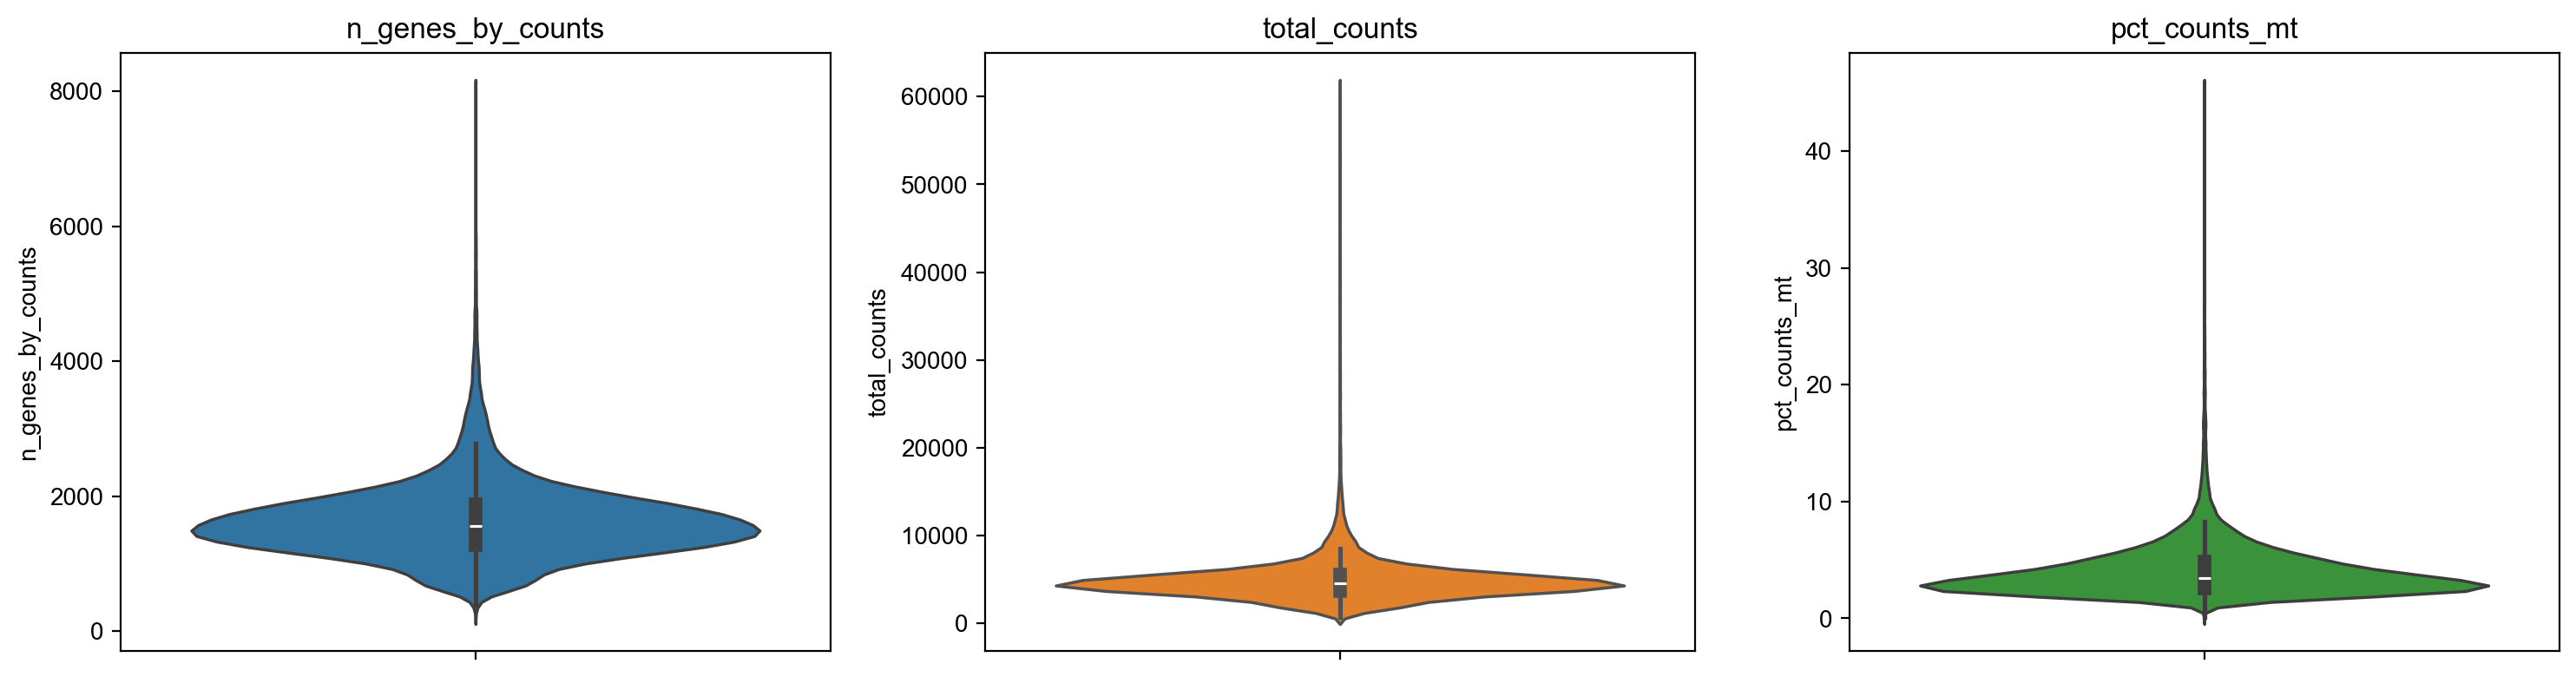

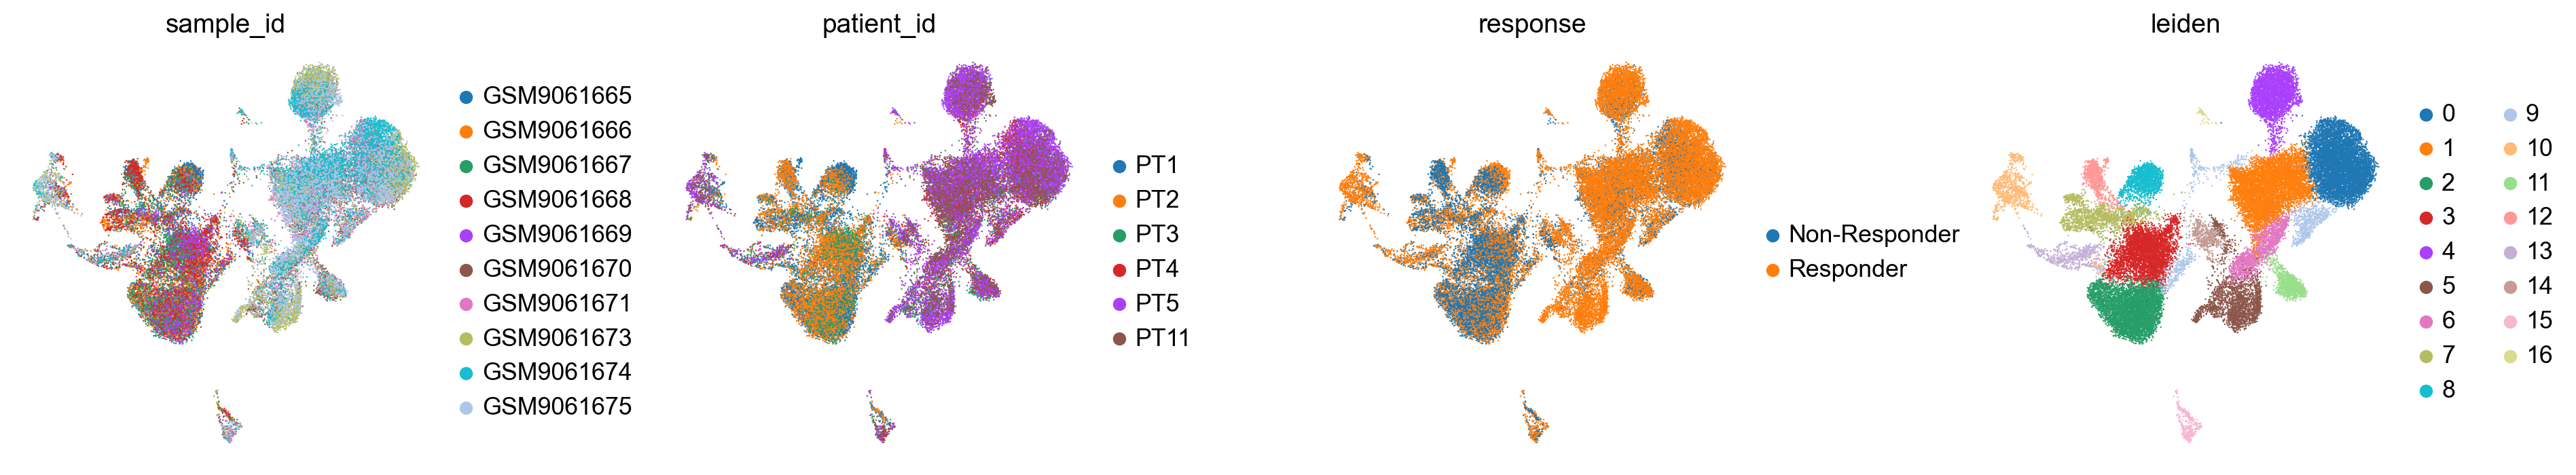

CPU times: total: 8.44 s
Wall time: 13.7 s


In [ ]:
%%time
# --- Install clustering packages ---
# igraph and leidenalg are required for Leiden clustering algorithm
%pip install igraph
%pip install leidenalg

# --- Clustering (Leiden algorithm) ---
# If clustering has not been performed, run Leiden algorithm to identify cell groups
if 'leiden' not in adata.obs:
    sc.tl.leiden(adata, resolution=0.6)

# --- Quality control (QC) violin plots ---
# Visualize distributions of key QC metrics: number of genes, total counts, percent mitochondrial genes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.violinplot(y=adata.obs['n_genes_by_counts'], ax=axes[0], color='C0')
axes[0].set_title('n_genes_by_counts')
sns.violinplot(y=adata.obs['total_counts'], ax=axes[1], color='C1')
axes[1].set_title('total_counts')
if 'pct_counts_mt' in adata.obs:
    sns.violinplot(y=adata.obs['pct_counts_mt'], ax=axes[2], color='C2')
    axes[2].set_title('pct_counts_mt')
else:
    axes[2].text(0.5, 0.5, "pct_counts_mt not available", ha='center')
plt.tight_layout()

# --- UMAP plots colored by key annotations ---
# Visualize UMAP embedding colored by sample, patient, response, and cluster assignments
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.pl.umap(adata, color=['sample_id', 'patient_id', 'response', 'leiden'], wspace=0.4, show=True)

# --- Create a clonotype identifier for each cell ---
# Prefer TRB CDR3 sequence, fallback to TRA if TRB is missing
cdr3_trb = adata.obs.get('cdr3_TRB')
cdr3_tra = adata.obs.get('cdr3_TRA')
clonotype_series = None


CPU times: total: 297 ms
Wall time: 297 ms


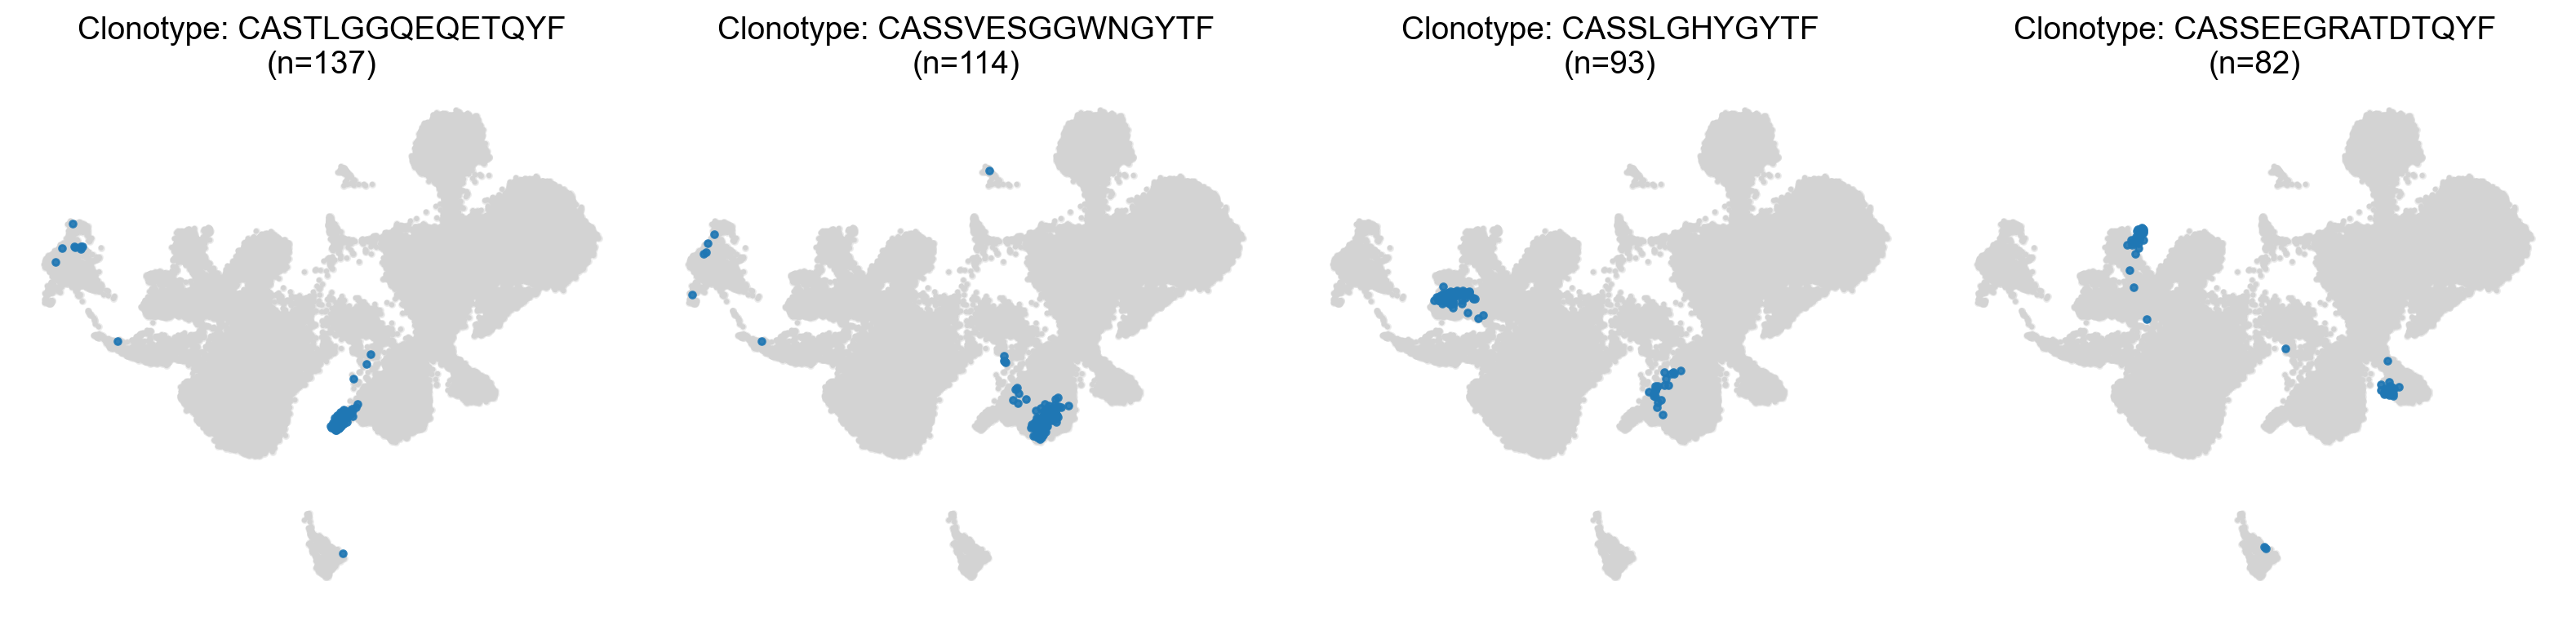

In [ ]:
%%time
# --- Create clonotype identifier for each cell ---
# Use TRB CDR3 sequence if available, otherwise use TRA. This helps group cells by TCR sequence.
cdr3_trb = adata.obs.get('cdr3_TRB')
cdr3_tra = adata.obs.get('cdr3_TRA')

if cdr3_trb is not None and cdr3_tra is not None:
    # If TRB is present, use it; otherwise, use TRA.
    clonotype_series = np.where(cdr3_trb.notna(), cdr3_trb.astype(str), cdr3_tra.astype(str))
elif cdr3_trb is not None:
    clonotype_series = cdr3_trb.astype(str)
elif cdr3_tra is not None:
    clonotype_series = cdr3_tra.astype(str)
else:
    clonotype_series = 'NA'

# Add clonotype information to AnnData.obs
adata.obs['clonotype'] = pd.Series(clonotype_series, index=adata.obs.index).fillna('NA').astype('category')

# --- Identify top clonotypes by cell count ---
top_n = 10  # Number of top clonotypes to display
top_clones = adata.obs[adata.obs['clonotype'] != 'NA']['clonotype'].value_counts().head(top_n)

# --- (Optional) Barplot of top clonotypes ---
# Uncomment below to show a barplot of top clonotypes
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.barplot(x=top_clones.values, y=top_clones.index, palette='viridis', ax=ax)
# ax.set_xlabel('Cell count')
# ax.set_title(f'Top {top_n} clonotypes (by cells)')
# # plt.tight_layout()

# --- UMAP highlighting top clonotypes ---
# For each of the top clonotypes, plot their location on the UMAP embedding
if not top_clones.empty:
    fig, axes = plt.subplots(1, min(4, len(top_clones)), figsize=(4 * min(4, len(top_clones)), 4))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax, clon in zip(axes, top_clones.index[:len(axes)]):
        mask = adata.obs['clonotype'] == clon
        # Plot all cells in light gray, highlight cells of the current clonotype
        sc.pl.umap(adata, color=None, ax=ax, show=False, size=20)
        ax.scatter(adata.obsm['X_umap'][~mask, 0], adata.obsm['X_umap'][~mask, 1], color='lightgray', s=5, alpha=0.4)
        ax.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1], s=8, alpha=0.9)
        ax.set_title(f'Clonotype: {clon}\n(n={mask.sum()})')
    plt.tight_layout()


In [ ]:
%%time
fig_dir = Path('../Processed_Data/figures')
# Ensure figures directory exists before any savefig calls
fig_dir.mkdir(parents=True, exist_ok=True)

# --- Clonotype distribution per patient (stacked bar plot) ---
# This section visualizes the distribution of the top clonotypes (most frequent TCR sequences) across patients.
# Each bar represents a patient, and the colors within the bar represent different clonotypes.
if not top_clones.empty:
    # Group the data by patient and clonotype, count the number of cells for each combination.
    clone_by_patient = (
        adata.obs[adata.obs['clonotype'].isin(top_clones.index)]
        .groupby(['patient_id', 'clonotype'])
        .size()
        .unstack(fill_value=0)
    )
    # Plot the stacked bar chart.
    clone_by_patient.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab20')
    plt.ylabel('Cell count')
    plt.title('Top clonotype counts per patient')
    plt.tight_layout()
    # Save the figure to the figures directory.
    plt.savefig(fig_dir / 'clonotype_by_patient.png', bbox_inches='tight')

# --- Summary prints ---
# Print the number of cells and genes in the processed AnnData object.
print("Number of cells:", adata.n_obs)
print("Number of genes:", adata.n_vars)
# Print the top clonotypes and their cell counts.
print("Top clonotypes:")
print(top_clones)

# --- Cluster vs Response Heatmap ---
# This section creates a heatmap showing the relationship between Leiden clusters (cell groupings) and treatment response.
# Each cell in the heatmap shows the number of cells in a cluster for each response category (Responder/Non-Responder).
cluster_response = adata.obs.groupby(['leiden', 'response']).size().unstack(fill_value=0)
plt.figure(figsize=(6, 4))
sns.heatmap(cluster_response, annot=True, fmt='d', cmap='Blues')
plt.title('Leiden cluster vs Response')
plt.ylabel('Leiden cluster')
plt.tight_layout()
# Save the heatmap to the figures directory.
plt.savefig(fig_dir / 'cluster_vs_response_heatmap.png', bbox_inches='tight')


<timed exec>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
<timed exec>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


Number of cells: 38413
Number of genes: 3000
Top clonotypes:
clonotype
CASTLGGQEQETQYF     137
CASSVESGGWNGYTF     114
CASSLGHYGYTF         93
CASSEEGRATDTQYF      82
CATSKDRESSYEQYF      80
CASRPDGGFTDTQYF      71
CATSREGISGANVLTF     70
CASSLDYGGPFGYTF      61
CASSPEGRKKAFF        51
CASSGGNQPQHF         51
Name: count, dtype: int64


<timed exec>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


CPU times: total: 12min 57s
Wall time: 13min 22s
